# Imitation Learning on Cartpole

In this question, we consider imitation learning on cartpole.

To begin with, please download the dataset:

data_obs.npy
data_acts.npy

# #1 Load the cartpole imitation data into memory.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_obs = np.load("datasets/data_obs.npy")
data_acts = np.load("datasets/data_acts.npy")

# #2 Write a feed forward neural network that takes as input the observations and predicts the actions.

Hold out 20% of your data as a test-set. Plot the learning curve with the x-axis being total training steps, and y-axis being test-set accuracy.

In [3]:
torch.manual_seed(300)
indices = np.random.permutation(data_obs.shape[0])
training_idx, test_idx = indices[:400], indices[400:]
train_obs, test_obs = data_obs[training_idx,:], data_obs[test_idx,:]
train_acts, test_acts = data_acts[training_idx,:], data_acts[test_idx,:]

In [4]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [5]:
def evaluate_model():
    with torch.no_grad():
        correct = 0
        total = 0
        inputs = torch.from_numpy(test_obs).float()
        targets = torch.from_numpy(test_acts).flatten()
        targets = targets.type(torch.LongTensor)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        test_accuracy.append(correct/total)

In [6]:
# Hyper-parameters
input_size = 4
hidden_size = 500
num_classes = 2
training_steps = 2000
learning_rate = 0.001

In [7]:
model = NeuralNet(input_size, hidden_size, num_classes)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
test_accuracy = []
for i in range(training_steps):
    inputs = torch.from_numpy(train_obs).float()
    targets = torch.from_numpy(train_acts).flatten()
    targets = targets.type(torch.LongTensor)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate model so far:
    evaluate_model()
    
    if (i+1) % 100 == 0:
        print ('Step [{}/{}], Loss: {:.4f}, Test accuracy: {}' 
               .format(i+1, training_steps, loss.item(), test_accuracy[i]))

Step [100/2000], Loss: 0.6483, Test accuracy: 0.75
Step [200/2000], Loss: 0.6281, Test accuracy: 0.75
Step [300/2000], Loss: 0.6105, Test accuracy: 0.8
Step [400/2000], Loss: 0.5948, Test accuracy: 0.84
Step [500/2000], Loss: 0.5805, Test accuracy: 0.88
Step [600/2000], Loss: 0.5676, Test accuracy: 0.9
Step [700/2000], Loss: 0.5559, Test accuracy: 0.91
Step [800/2000], Loss: 0.5452, Test accuracy: 0.92
Step [900/2000], Loss: 0.5354, Test accuracy: 0.93
Step [1000/2000], Loss: 0.5265, Test accuracy: 0.94
Step [1100/2000], Loss: 0.5183, Test accuracy: 0.95
Step [1200/2000], Loss: 0.5107, Test accuracy: 0.95
Step [1300/2000], Loss: 0.5037, Test accuracy: 0.95
Step [1400/2000], Loss: 0.4973, Test accuracy: 0.96
Step [1500/2000], Loss: 0.4913, Test accuracy: 0.96
Step [1600/2000], Loss: 0.4858, Test accuracy: 0.96
Step [1700/2000], Loss: 0.4807, Test accuracy: 0.96
Step [1800/2000], Loss: 0.4759, Test accuracy: 0.96
Step [1900/2000], Loss: 0.4714, Test accuracy: 0.96
Step [2000/2000], Loss:

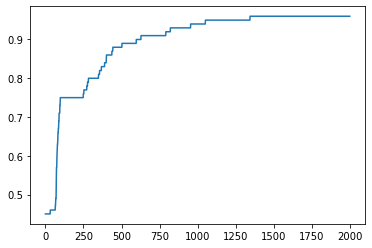

In [10]:
plt.plot(test_accuracy)

# #3 Run this trained imitation policy on cartpole.

Make a learning curve that shows on the x-axis the number of training steps, and on the y-axis the performance on cartpole (number of steps survived).

Note that to do this, you will need to periodically stop training the neural network to test the policy on cartpole.

At convergence, how many steps can the imitation learning policy last? To answer this last question, please run the converged cartpole policy several times and report the average number of steps survived. That is, call env.reset(), and run the imitation policy until failure. Do this several times, reporting the average time until failure.

In [11]:
import gym
import statistics as stat

In [12]:
def run_cartpole(horizon):
    # To make output consistent
    np.random.seed(43)

    # This makes the cartpole env
    env = gym.make('CartPole-v1')

    env.action_space.seed(43)
    env.observation_space.seed(43)

    obs, info = env.reset()

    terminated = False
    for j in range(horizon):
        if terminated is False:
            obs = torch.from_numpy(obs).float()
            outputs = model(obs)
            _, action = torch.max(outputs, 0)
            action = action.numpy()
            next_obs, reward, terminated, truncated, info = env.step(action)
            obs = next_obs
        else:
            print("Fell at step: {}".format(j+1))
            num_steps.append(j+1)
            break
        
        if j+1 == horizon:
            print("Made it to horizon")
            num_steps.append(j+1)

In [13]:
horizon = 500

In [14]:
model = NeuralNet(input_size, hidden_size, num_classes)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
num_steps = []
for i in range(training_steps):
    inputs = torch.from_numpy(train_obs).float()
    targets = torch.from_numpy(train_acts).flatten()
    targets = targets.type(torch.LongTensor)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate model so far:
    run_cartpole(horizon)
    
    if (i+1) % 100 == 0:
        print ('Step [{}/{}], Loss: {:.4f}, Number of steps: {}' 
               .format(i+1, training_steps, loss.item(), num_steps[i]))

Fell at step: 10
Fell at step: 10
Fell at step: 11
Fell at step: 10
Fell at step: 10
Fell at step: 11
Fell at step: 11
Fell at step: 10
Fell at step: 10
Fell at step: 11
Fell at step: 9
Fell at step: 10
Fell at step: 11
Fell at step: 10
Fell at step: 11
Fell at step: 10
Fell at step: 12
Fell at step: 10
Fell at step: 11
Fell at step: 11
Fell at step: 10
Fell at step: 10
Fell at step: 11
Fell at step: 10
Fell at step: 9
Fell at step: 11
Fell at step: 10
Fell at step: 10
Fell at step: 10
Fell at step: 10
Fell at step: 10
Fell at step: 11
Fell at step: 11
Fell at step: 11
Fell at step: 10
Fell at step: 11
Fell at step: 10
Fell at step: 11
Fell at step: 10
Fell at step: 11
Fell at step: 10
Fell at step: 10
Fell at step: 11
Fell at step: 11
Fell at step: 10
Fell at step: 11
Fell at step: 9
Fell at step: 10
Fell at step: 10
Fell at step: 10
Fell at step: 10
Fell at step: 11
Fell at step: 11
Fell at step: 9
Fell at step: 11
Fell at step: 11
Fell at step: 9
Fell at step: 11
Fell at step: 10
Fe

Fell at step: 108
Fell at step: 89
Fell at step: 82
Fell at step: 62
Fell at step: 55
Fell at step: 141
Fell at step: 89
Fell at step: 49
Fell at step: 55
Fell at step: 88
Fell at step: 76
Fell at step: 169
Fell at step: 105
Fell at step: 55
Fell at step: 139
Fell at step: 77
Fell at step: 51
Fell at step: 106
Fell at step: 64
Fell at step: 65
Step [500/2000], Loss: 0.5737, Number of steps: 65
Fell at step: 115
Fell at step: 97
Fell at step: 102
Fell at step: 51
Fell at step: 73
Fell at step: 107
Fell at step: 138
Fell at step: 64
Fell at step: 68
Fell at step: 117
Fell at step: 141
Fell at step: 104
Fell at step: 75
Fell at step: 110
Fell at step: 70
Fell at step: 91
Fell at step: 85
Fell at step: 81
Fell at step: 95
Fell at step: 74
Fell at step: 78
Fell at step: 58
Fell at step: 68
Fell at step: 151
Fell at step: 55
Fell at step: 128
Fell at step: 74
Fell at step: 89
Fell at step: 81
Fell at step: 105
Fell at step: 63
Fell at step: 79
Fell at step: 124
Fell at step: 76
Fell at step:

Fell at step: 66
Fell at step: 133
Fell at step: 65
Fell at step: 67
Fell at step: 97
Fell at step: 100
Fell at step: 139
Fell at step: 80
Fell at step: 70
Fell at step: 134
Fell at step: 67
Fell at step: 147
Fell at step: 149
Fell at step: 106
Fell at step: 60
Fell at step: 89
Fell at step: 155
Fell at step: 59
Fell at step: 99
Fell at step: 58
Fell at step: 63
Fell at step: 88
Fell at step: 69
Fell at step: 70
Fell at step: 51
Fell at step: 91
Fell at step: 71
Fell at step: 153
Fell at step: 79
Fell at step: 161
Fell at step: 74
Fell at step: 74
Fell at step: 141
Fell at step: 126
Fell at step: 81
Fell at step: 85
Fell at step: 171
Fell at step: 154
Fell at step: 182
Fell at step: 141
Fell at step: 119
Fell at step: 124
Fell at step: 57
Fell at step: 93
Fell at step: 76
Fell at step: 77
Fell at step: 82
Fell at step: 153
Fell at step: 139
Fell at step: 94
Fell at step: 79
Fell at step: 127
Fell at step: 89
Fell at step: 58
Fell at step: 77
Fell at step: 116
Fell at step: 127
Fell at 

Fell at step: 145
Fell at step: 110
Fell at step: 121
Fell at step: 86
Fell at step: 70
Fell at step: 91
Fell at step: 160
Fell at step: 73
Fell at step: 64
Fell at step: 64
Fell at step: 134
Fell at step: 80
Fell at step: 118
Fell at step: 105
Fell at step: 93
Fell at step: 125
Fell at step: 101
Fell at step: 72
Fell at step: 100
Fell at step: 51
Fell at step: 61
Fell at step: 67
Fell at step: 73
Fell at step: 61
Fell at step: 67
Fell at step: 59
Fell at step: 68
Fell at step: 64
Fell at step: 183
Fell at step: 194
Fell at step: 97
Fell at step: 65
Fell at step: 77
Fell at step: 68
Fell at step: 62
Fell at step: 81
Fell at step: 94
Fell at step: 73
Fell at step: 59
Fell at step: 120
Fell at step: 61
Fell at step: 61
Fell at step: 85
Fell at step: 192
Fell at step: 143
Fell at step: 150
Fell at step: 65
Fell at step: 65
Fell at step: 55
Fell at step: 149
Fell at step: 137
Fell at step: 112
Fell at step: 167
Fell at step: 58
Fell at step: 118
Fell at step: 79
Fell at step: 79
Fell at st

Fell at step: 89
Fell at step: 93
Fell at step: 63
Fell at step: 92
Fell at step: 87
Fell at step: 80
Fell at step: 172
Fell at step: 120
Fell at step: 108
Fell at step: 121
Step [1900/2000], Loss: 0.4551, Number of steps: 121
Fell at step: 85
Fell at step: 74
Fell at step: 62
Fell at step: 94
Fell at step: 97
Fell at step: 89
Fell at step: 65
Fell at step: 53
Fell at step: 128
Fell at step: 65
Fell at step: 87
Fell at step: 96
Fell at step: 57
Fell at step: 143
Fell at step: 64
Fell at step: 76
Fell at step: 79
Fell at step: 73
Fell at step: 116
Fell at step: 93
Fell at step: 110
Fell at step: 71
Fell at step: 143
Fell at step: 117
Fell at step: 84
Fell at step: 147
Fell at step: 81
Fell at step: 119
Fell at step: 81
Fell at step: 62
Fell at step: 57
Fell at step: 151
Fell at step: 69
Fell at step: 87
Fell at step: 105
Fell at step: 91
Fell at step: 67
Fell at step: 67
Fell at step: 72
Fell at step: 118
Fell at step: 65
Fell at step: 49
Fell at step: 149
Fell at step: 127
Fell at step

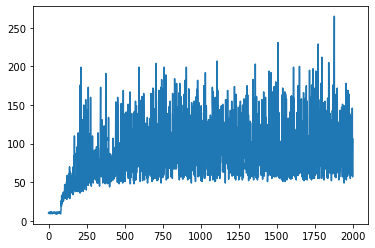

In [17]:
plt.plot(num_steps)

In [18]:
num_i = 200

In [19]:
num_steps = []
for i in range(num_i):
    run_cartpole(horizon)

Fell at step: 87
Fell at step: 104
Fell at step: 117
Fell at step: 111
Fell at step: 85
Fell at step: 86
Fell at step: 87
Fell at step: 110
Fell at step: 72
Fell at step: 83
Fell at step: 69
Fell at step: 111
Fell at step: 88
Fell at step: 141
Fell at step: 171
Fell at step: 116
Fell at step: 157
Fell at step: 56
Fell at step: 89
Fell at step: 67
Fell at step: 116
Fell at step: 63
Fell at step: 59
Fell at step: 65
Fell at step: 109
Fell at step: 84
Fell at step: 136
Fell at step: 113
Fell at step: 85
Fell at step: 75
Fell at step: 65
Fell at step: 116
Fell at step: 95
Fell at step: 66
Fell at step: 82
Fell at step: 51
Fell at step: 90
Fell at step: 85
Fell at step: 53
Fell at step: 83
Fell at step: 81
Fell at step: 117
Fell at step: 89
Fell at step: 149
Fell at step: 53
Fell at step: 88
Fell at step: 60
Fell at step: 63
Fell at step: 73
Fell at step: 84
Fell at step: 130
Fell at step: 65
Fell at step: 59
Fell at step: 59
Fell at step: 66
Fell at step: 141
Fell at step: 81
Fell at step:

In [20]:
stat.mean(num_steps)

95.065

# # 4 Plot your results.
Take the converged imitation learning policy. Use it to run the cartpole environment forward.


On the x-axis, plot the current timestep in the cartpole environment. On the y-axis, plot the observation values. Since the observation space is 4 dimensional, you should have 4 different curves, one for each observation over time.

In [21]:
# To make output consistent
np.random.seed(42)

# This makes the cartpole env
env = gym.make('CartPole-v1')

env.action_space.seed(42)
env.observation_space.seed(42)

obs, info = env.reset()

In [22]:
x, v, theta, v_theta = obs

In [23]:
horizon = 500
terminated = False

In [24]:
obs_list = [obs]
for i in range(horizon):
    if terminated is False:
        obs = torch.from_numpy(obs).float()
        outputs = model(obs)
        _, action = torch.max(outputs, 0)
        action = action.numpy()
        next_obs, reward, terminated, truncated, info = env.step(action)
        obs = next_obs
        obs_list.append(obs)
    else:
        print("Fell at {} steps".format(i))
        break
    if i+1 == horizon:
        print("Reached horizon")

Fell at 52 steps


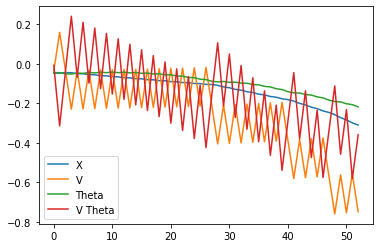

In [25]:
plt.plot(obs_list, label = ["X", "V", "Theta", "V Theta"])
plt.legend()

# #5 Robustness to random starts.

Each time you restart cartpole, instead of taking actions from the policy at the start, take random actions first for K steps.

For this modified cartpole, print a robustness curve, where the x-axis is the number of random actions before the imitation policy takes over (K above) and the y-axis is the number of actions the imtation policy survives AFTER taking over.

Note that the y-axis value might be noisy, and you might need to average it over 5-20 runs.

In [26]:
num_k = 50
num_i = 10
horizon = 500
avg_steps = []

In [27]:
def update_avg_steps(k, steps, i):
    if i==0:
        avg_steps.append(steps)        
    else:
        avg_steps[k] = (avg_steps[k] * (i)/(i+1)) + (steps)/(i+1)

In [28]:
def k_random_actions(k,i):
    terminated = False
    for j in range(k+1):
        if terminated is False:
            obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
            if terminated is True:
                update_avg_steps(k,0,i)
                return obs, reward, terminated, truncated, info
    return obs, reward, terminated, truncated, info

In [29]:
# To make output consistent
np.random.seed(42)

avg_steps = []
for k in range(num_k):
    for i in range(num_i):
        # This makes the cartpole env
        env = gym.make('CartPole-v1')

        env.action_space.seed(42)
        env.observation_space.seed(42)

        obs, info = env.reset()
        

        # Take k random actions:
        obs, reward, terminated, truncated, info = k_random_actions(k,i)
        
        x, v, theta, v_theta = obs

        if terminated is False:
            for j in range(horizon):
                if terminated is False:
                    obs = torch.from_numpy(obs).float()
                    outputs = model(obs)
                    _, action = torch.max(outputs, 0)
                    action = action.numpy()
                    next_obs, reward, terminated, truncated, info = env.step(action)
                    obs = next_obs
                else:
                    update_avg_steps(k, j+1, i)
                    break
                if j+1 == horizon:
                    update_avg_steps(k, j+1, i)

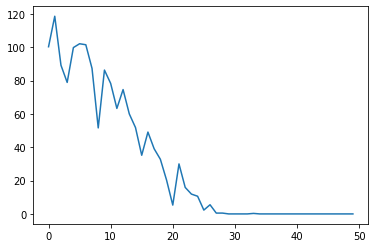

In [30]:
plt.plot(avg_steps)